# Environment setup

## Download code and data


In [1]:
!pip install imagecodecs tifffile

     |████████████████████████████████| 17.9MB 199kB/s 


In [2]:
# Clone the GitHub repository and cd into it
!git clone 'https://github.com/CRefice/ml-segmentation-project.git'
%cd ml-segmentation-project/

Cloning into 'ml-segmentation-project'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 58 (delta 30), reused 36 (delta 15), pack-reused 0
Unpacking objects: 100% (58/58), done.
/content/ml-segmentation-project


In [3]:
# Download the data using the fetch script
!./fetch-data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72.8M  100 72.8M    0     0  5767k      0  0:00:12  0:00:12 --:--:-- 11.5M


## Useful imports and settings

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms, datasets, models
import copy
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

import unet
from dataset import CellSegmentationDataset


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data importing and massaging

Now we import the dataset and create train/test splitters.

In [79]:
BATCH_SIZE = 16
TRAIN_SIZE = 2000

img_transforms = transforms.Compose([
      # Convert to 0-1 float
      transforms.Lambda(lambda img: img.astype(np.float32) / np.iinfo(img.dtype).max), 
      transforms.ToTensor(),
      transforms.CenterCrop(572),
])
target_transforms = transforms.Compose([
      transforms.Lambda(lambda img: img.astype(np.float32)),
      transforms.ToTensor(),
      # Limit to 0-1 for foreground-background segmentation
      transforms.Lambda(lambda img: img.clamp(max=1.0)),
      transforms.CenterCrop(572),
])

dataset = CellSegmentationDataset(raw_img_dir=Path("dataset/rawimages"),
                                  ground_truth_dir=Path("dataset/groundtruth"),
                                  pattern="Neuroblastoma",
                                  transform=img_transforms,
                                  target_transform=target_transforms,
                                )

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

<Figure size 432x288 with 0 Axes>

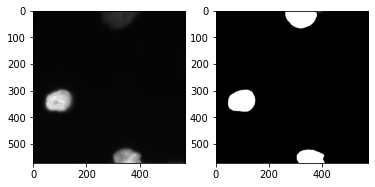

In [84]:
plt.gray()
f, axes = plt.subplots(1, 2)
image, segm = dataset[1]
axes[0].imshow(image.permute(1, 2, 0).squeeze())
axes[1].imshow(segm.permute(1, 2, 0).squeeze())
plt.show()

# Training

In [47]:
model = unet.UNet().to(device)

In [48]:
summary(model, input_size=(1, 572, 572))

<built-in method size of Tensor object at 0x7f963f0733f0>
torch.Size([2, 2, 388, 388])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 570, 570]             640
              ReLU-2         [-1, 64, 570, 570]               0
            Conv2d-3         [-1, 64, 568, 568]          36,928
              ReLU-4         [-1, 64, 568, 568]               0
         MaxPool2d-5         [-1, 64, 284, 284]               0
            Conv2d-6        [-1, 128, 282, 282]          73,856
              ReLU-7        [-1, 128, 282, 282]               0
            Conv2d-8        [-1, 128, 280, 280]         147,584
              ReLU-9        [-1, 128, 280, 280]               0
        MaxPool2d-10        [-1, 128, 140, 140]               0
           Conv2d-11        [-1, 256, 138, 138]         295,168
             ReLU-12        [-1, 256, 138, 138]               0
           Conv2

In [ ]:
TRN_EPOCHS = 10
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.01
MOMENTUM = 0.99

def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10e3

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            epoch_loss = []
            
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                                      
                epoch_loss.append(loss)
            
            print("Epoch {} loss: {}".format(phase, np.mean(epoch_loss)))
                
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


model = unet.UNet()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss()

# Maybe interesting to use later
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, criterion, exp_lr_scheduler, num_epochs=TRN_EPOCHS)